In [57]:
#Dataset chosen - https://www.kaggle.com/phyamal/glasgow-weather-data-20152019
# Problem statement - 
#Using TimeSeries to observe the trend and predict the temperature in upcoming 'n' number of years


In [58]:
#Imports

from datetime import datetime, timedelta
import time
from collections import namedtuple
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as StatsModelAPI
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import itertools
import math
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Just don't want warnings.
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Reading the dataframe.

df = pd.read_csv('clean_weather_data.csv')

In [60]:
df.head(5)

,day,tempMin,tempMax,summary,desc,cloudCover,humidity,windSpeed,visibility
0,2015-01-01,7.53,12.23,Possible light rain until evening.,rain,0.80,0.89,14.69,4.43
1,2015-01-02,3.58,7.15,Possible light rain throughout the day.,rain,0.62,0.79,15.04,5.64
2,2015-01-03,-0.61,6.54,Clear throughout the day.,rain,0.31,0.84,4.48,6.20
3,2015-01-04,-0.63,7.59,Mostly cloudy throughout the day.,partly-cloudy-day,0.78,0.85,4.35,6.22
4,2015-01-05,6.51,10.43,Overcast throughout the day.,partly-cloudy-day,0.85,0.91,6.20,5.91


In [61]:
# View the dtypes of dataframe. And fix it accordingly.

df.dtypes

day            object
tempMin       float64
tempMax       float64
summary        object
desc           object
cloudCover    float64
humidity      float64
windSpeed     float64
visibility    float64
dtype: object

In [62]:
 #Day to timestamp object, We'll use dataframe.apply to do it.

df['day'] = df['day'].apply(pd.to_datetime)
df = df.set_index('day')

In [63]:
# Add mean temperature column.

temp = df['tempMin'] + df['tempMax']
temp = temp/2
df['tempMean'] = temp

In [64]:
#Monthly data of temperatures. Because ARIMA has seasonal default applications too.


df = df.resample('1M').mean()

In [65]:
df.head(5)

,tempMin,tempMax,cloudCover,humidity,windSpeed,visibility,tempMean
day,,,,,,,
2015-01-31,1.470000,6.816129,0.623548,0.851935,10.118710,5.525161,4.143065
2015-02-28,1.364643,7.349643,0.615714,0.846429,7.193214,5.687857,4.357143
2015-03-31,2.402258,9.188065,0.613226,0.810000,8.567419,5.657419,5.795161
2015-04-30,2.987333,12.908667,0.440000,0.759333,5.930000,5.651667,7.948000
2015-05-31,5.861935,12.806452,0.588065,0.761290,8.428387,6.036129,9.334194


In [66]:
# Adding a column of temperature mean.

df = df['tempMean']

In [67]:
#Saving the dataset to a csv.


df.to_csv("train.csv")

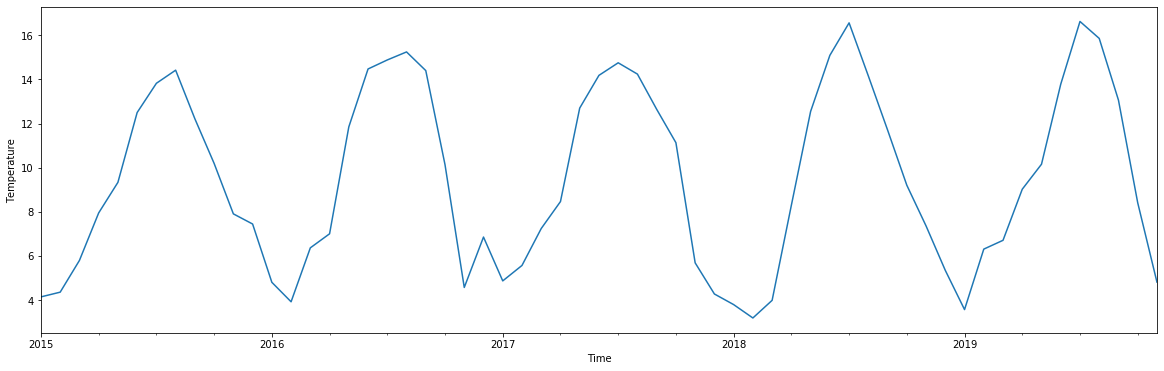

In [68]:

#Plot the temperature time Series to observe the trend.


df.plot(figsize=(20, 6))
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

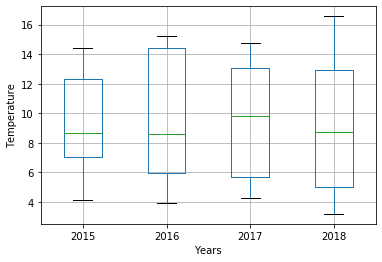

In [69]:
#Observe the box plot of the temperatures of every year


groups = df['2015':].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  try:
    years[name.year] = group.values
  except:
    pass

plt.xlabel('Years')
plt.ylabel('Temperature')
years.boxplot()
plt.show()

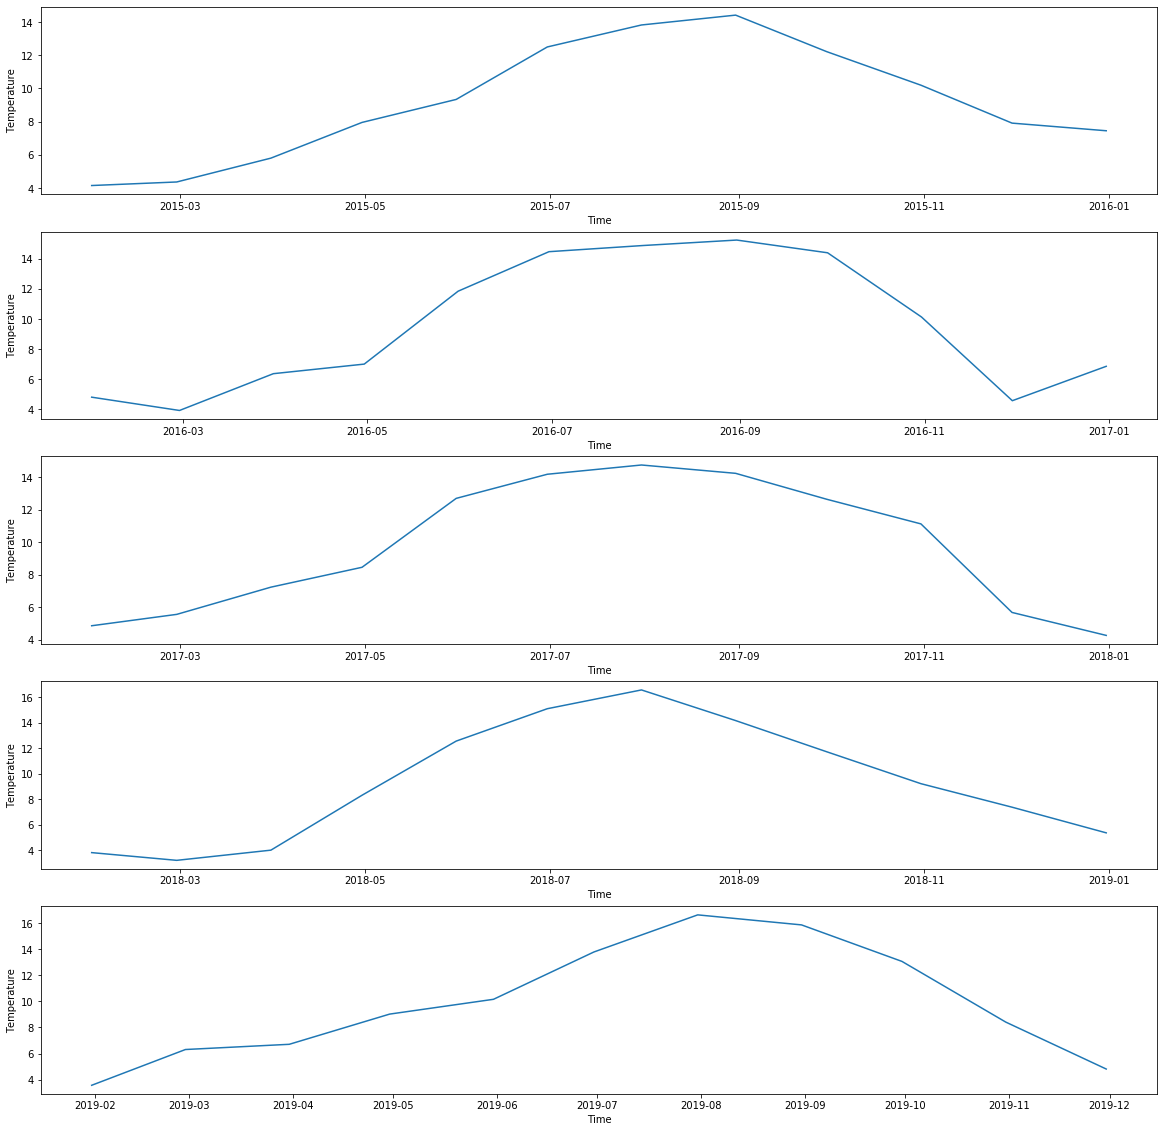

In [70]:
#Observe trend for every year.
# By observation, the trend rises in month of August and September mostly at max.

groups = df['2015':'2019'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
plt.figure(figsize=(20, 20))
i = 1
n_groups = len(groups)
for name, group in groups:
  plt.subplot((n_groups*100) + 10 + i)
  i += 1
  plt.plot(group)
  plt.xlabel('Time')
  plt.ylabel('Temperature')
plt.show()

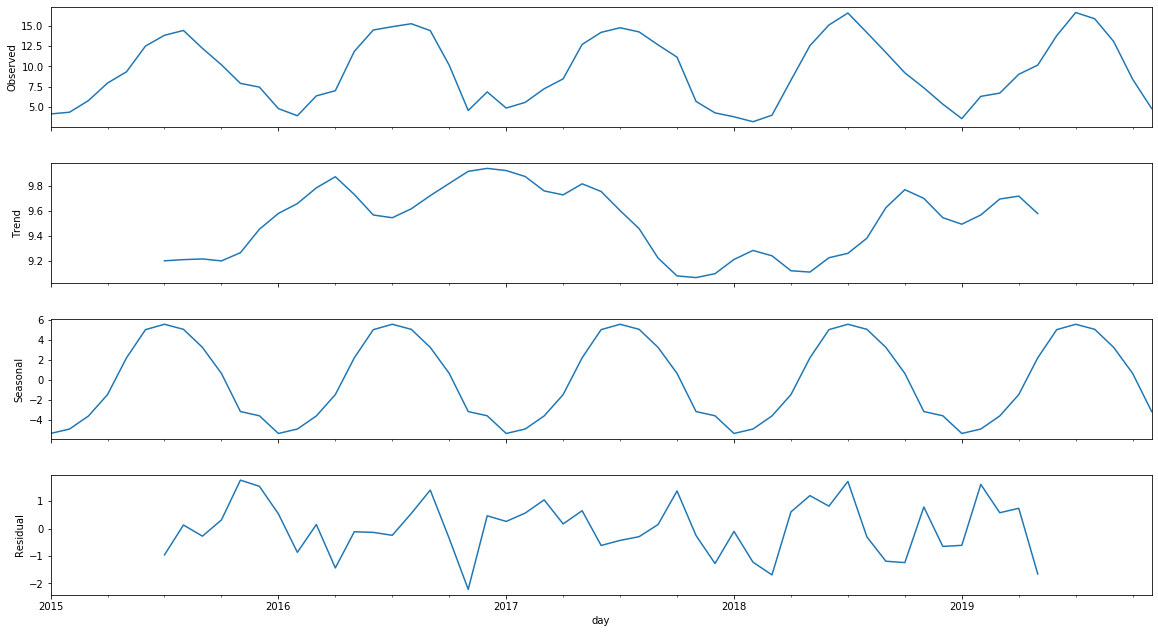

In [82]:
#Observe the trend, seasonality and noise.
#Using additive model - Y[t] = T[t] + S[t] + e[t]


decomposition = StatsModelAPI.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.show()

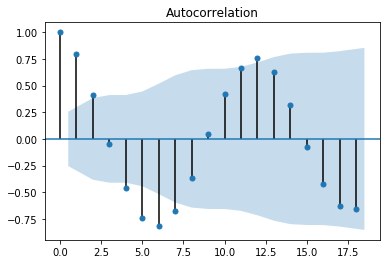

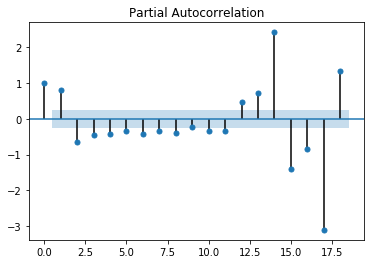

In [72]:
#Autocorrection and partial autocorrection.


plot_acf(df)
plt.show()

plot_pacf(df)
plt.show()

In [83]:
#Grid Searching for best parameters for ARIMAX API model
#This will take around 10-20 mins to get best parameter
# We will take minimum RMS value for the model



p =  range(0, 7)
d =  range(0, 3)
q =  range(0, 7)

# form all combinations of pdq
pdq = list(itertools.product(p, d, q))

best_param = None

lowest_rms = math.inf

for param in pdq:
 try:
    mod = StatsModelAPI.tsa.statespace.SARIMAX(df, order=param, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    rms = sqrt(abs(results.aic))
    if rms < lowest_rms:
      lowest_rms = rms
      best_param = param
    print("Checking (p, d, q) - ",param," with rms - ",rms)
 except:
      continue
print("Best parameters for this models - ",best_param)

Checking (p, d, q) -  (0, 0, 0)  with rms -  20.93417615451738
Checking (p, d, q) -  (0, 0, 1)  with rms -  19.10723837582432
Checking (p, d, q) -  (0, 0, 2)  with rms -  17.891982101577135
Checking (p, d, q) -  (0, 0, 3)  with rms -  16.96032180692398
Checking (p, d, q) -  (0, 0, 4)  with rms -  16.426923326373707
Checking (p, d, q) -  (0, 0, 5)  with rms -  15.854373982073598
Checking (p, d, q) -  (0, 0, 6)  with rms -  15.55401030440531
Checking (p, d, q) -  (0, 1, 0)  with rms -  16.369502311014433
Checking (p, d, q) -  (0, 1, 1)  with rms -  15.870291270038523
Checking (p, d, q) -  (0, 1, 2)  with rms -  15.650720347203261
Checking (p, d, q) -  (0, 1, 3)  with rms -  15.772934454922106
Checking (p, d, q) -  (0, 1, 4)  with rms -  15.204093536433612
Checking (p, d, q) -  (0, 1, 5)  with rms -  15.086898613621786
Checking (p, d, q) -  (0, 1, 6)  with rms -  15.242684301402763
Checking (p, d, q) -  (0, 2, 0)  with rms -  16.0683880399154
Checking (p, d, q) -  (0, 2, 1)  with rms -  1

Checking (p, d, q) -  (6, 0, 3)  with rms -  14.216267604885312
Checking (p, d, q) -  (6, 0, 4)  with rms -  14.293142523946019
Checking (p, d, q) -  (6, 0, 5)  with rms -  14.198749264321298
Checking (p, d, q) -  (6, 0, 6)  with rms -  13.773916078521893
Checking (p, d, q) -  (6, 1, 0)  with rms -  14.350386987181244
Checking (p, d, q) -  (6, 1, 1)  with rms -  13.665206677728438
Checking (p, d, q) -  (6, 1, 2)  with rms -  13.737880150818524
Checking (p, d, q) -  (6, 1, 3)  with rms -  13.663502974509564
Checking (p, d, q) -  (6, 1, 4)  with rms -  13.587312378238313
Checking (p, d, q) -  (6, 1, 5)  with rms -  13.397675262411948
Checking (p, d, q) -  (6, 1, 6)  with rms -  13.601905802226861
Checking (p, d, q) -  (6, 2, 0)  with rms -  15.255645824402249
Checking (p, d, q) -  (6, 2, 1)  with rms -  14.462124871718927
Checking (p, d, q) -  (6, 2, 2)  with rms -  13.986827330429128
Checking (p, d, q) -  (6, 2, 3)  with rms -  14.00550827360534
Checking (p, d, q) -  (6, 2, 4)  with rms

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2754      0.215      1.278      0.201      -0.147       0.698
ar.L2          1.0589      0.106      9.969      0.000       0.851       1.267
ar.L3         -0.4369      0.215     -2.034      0.042      -0.858      -0.016
ar.L4         -0.8747      0.112     -7.824      0.000      -1.094      -0.656
ar.L5          0.2348      0.191      1.232      0.218      -0.139       0.608
ma.L1         -0.8296      4.846     -0.171      0.864     -10.327       8.668
ma.L2         -1.4845      1.062     -1.398      0.162      -3.565       0.596
ma.L3          1.3997      9.683      0.145      0.885     -17.578      20.377
ma.L4          0.9687      0.837      1.157      0.247      -0.672       2.610
ma.L5         -1.0703      6.381     -0.168      0.867     -13.577      11.436
sigma2         0.8121      4.796      0.169      0.8

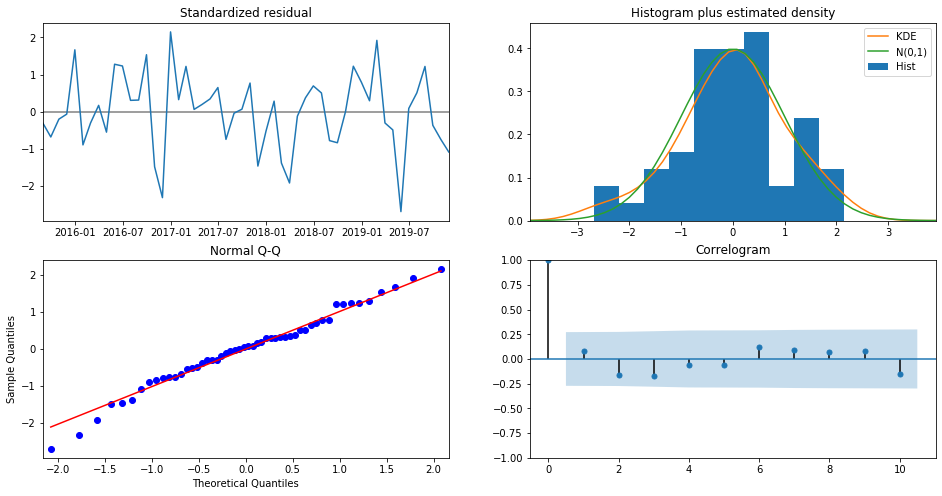

In [78]:
# Validating the model and observing the diagnostics of it.


mod = StatsModelAPI.tsa.statespace.SARIMAX(df, order=best_param, enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(16, 8))
plt.show()

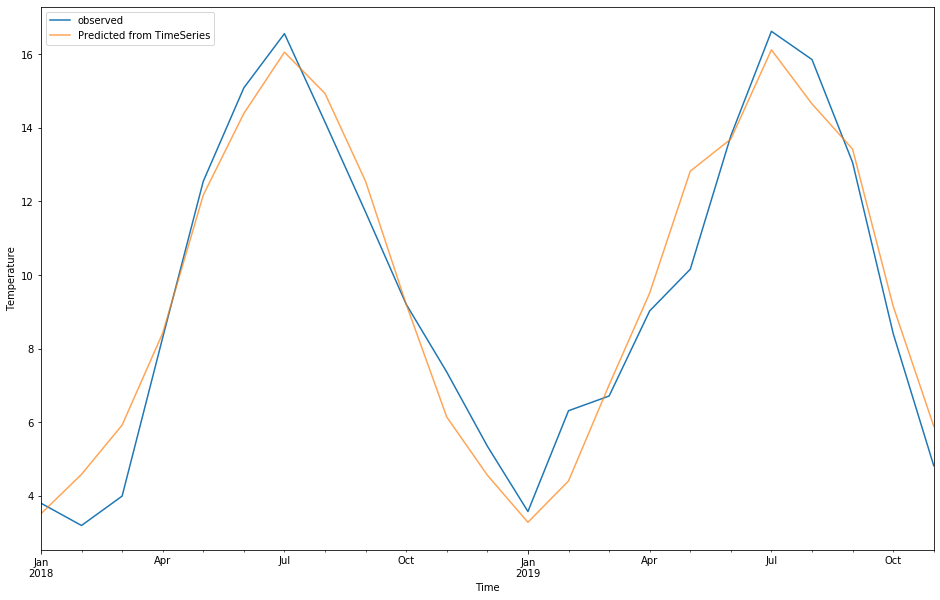

In [79]:
# Watch the prediction model to predict the test dataset. i.e. from 2018 onwards.
#Plotted observed vs predicted temperature


pred = results.get_prediction(start=pd.to_datetime('2018-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted from TimeSeries', alpha=.7, figsize=(16, 10))
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [80]:

# Calculating the rms value of the predicted model.


df_predicted = pred.predicted_mean
df_observed = df['2018':]
mse = ((df_observed - df_predicted) ** 2).mean()
rms = round(np.sqrt(mse), 2)
print('The Root Mean Squared Error of our prediction is ', rms)

The Root Mean Squared Error of our prediction is  1.04


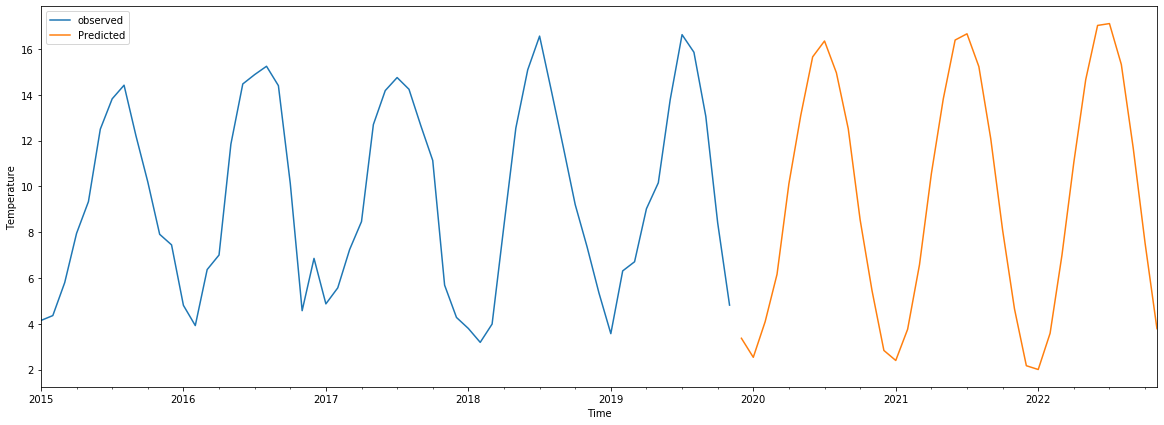

In [81]:
 #Predicting the forecast for next 3 years.
 #Also saving the prediction to csv file.


years_to_predict = 3
steps = years_to_predict*12

pred_model = results.get_forecast(steps=steps)
pred = pred_model.predicted_mean

pred.to_csv("pred_" + str(years_to_predict) + "_years.csv")


ax = df.plot(label='observed', figsize=(20, 7))
pred.plot(ax=ax, label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()